In [19]:
! pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [1]:
%%capture
! pip install --upgrade pip
! pip install "numpy<2"
! pip install llama-index
! pip install llama-index-experimental
! pip intstall arize-phoenix
! pip install pyvis
! pip install llama-index-embeddings-ollama
! pip install llama-index-llms-ollama
! pip install instructor

! pip install llama-index-llms-bedrock
! pip install llama-index-embeddings-bedrock
! pip install openpyxl
! pip install matplotlib

In [2]:
import logging
import sys
from IPython.display import Markdown, display

IS_LOCAL = False

logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

httpx_logger = logging.getLogger("httpx")
httpx_logger.setLevel(logging.ERROR)


In [3]:
# !wget 'https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/docs/examples/data/csv/titanic_train.csv' -O 'titanic_train.csv'

In [4]:
if IS_LOCAL:
    # If using LlamaIndex with Ollama, this is how you can set it up
    from llama_index.embeddings.ollama import OllamaEmbedding
    from llama_index.core import Settings
    from llama_index.llms.ollama import Ollama

    ollama_embedding = OllamaEmbedding(
        model_name="mxbai-embed-large:latest",
        base_url="http://localhost:11434",
    )

    passages_embedding = ollama_embedding.get_text_embedding_batch(
        ["This is a passage!"], show_progress=False, max_retries=1
    )
    print(passages_embedding[0][:5])

    # Setup LlamaIndex setting singleton
    Settings.embed_model = ollama_embedding
    Settings.llm = Ollama(model="codellama:13b", request_timeout=240.0,)
    # Settings.llm = Ollama(model="llama3.2:latest", request_timeout=240.0)

In [5]:
if not IS_LOCAL:
    # If using LlamaIndex with Bedrock, this is how you can set it up

    from llama_index.embeddings.bedrock import BedrockEmbedding
    from llama_index.llms.bedrock import Bedrock
    from llama_index.core import Settings
    import os
    
    from dotenv import load_dotenv

    load_dotenv(verbose=True, dotenv_path=".env")
    
    embedding_model = "amazon.titan-embed-text-v2:0"
    print(f"Setting up remote Retriever model (embedding: {embedding_model})...")
    Settings.embed_model = BedrockEmbedding(
        model_name=embedding_model,
        region_name=os.environ["AWS_DEFAULT_REGION"],
    )
    Settings.chunk_size = 1024
    Settings.chunk_overlap = 20
            
    # Setup Generator model
    # llm_model = "anthropic.claude-3-5-sonnet-20241022-v2:0"
    llm_model = "anthropic.claude-3-haiku-20240307-v1:0"
    print(f"Setting up remote Generator model (main LLM: {llm_model})...")
    Settings.llm = Bedrock(
        model=llm_model,
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        aws_session_token=os.environ["AWS_SESSION_TOKEN"],
        region_name=os.environ["AWS_DEFAULT_REGION"],
        context_window=8192,
        request_timeout=120,
    )

Setting up remote Retriever model (embedding: amazon.titan-embed-text-v2:0)...
Setting up remote Generator model (main LLM: anthropic.claude-3-haiku-20240307-v1:0)...


In [6]:
from llama_index.experimental.query_engine.pandas import PandasQueryEngine
import pandas as pd

df = pd.read_excel("./titanic_train.xlsx")
query_engine = PandasQueryEngine(
    df=df,
    verbose=True,
    description="This dataframe contains passenger information from the Titanic.",
)



In [7]:
easy_questions = [
    "How many passengers were onboard?",
    "What is the average age of the passengers?",
    "What is the average fare paid by the passengers?",
    "What is the average number of siblings/spouses aboard?",
    "What is the average number of parents/children aboard?"
]

for question in easy_questions:
    display(Markdown(f"**{question}**:"))
    response = query_engine.query(question)
    display(Markdown(f"{response}"))

**How many passengers were onboard?**:

> Pandas Instructions:
```
len(df)
```
> Pandas Output: 891


891

**What is the average age of the passengers?**:

> Pandas Instructions:
```
df['age'].mean()
```
> Pandas Output: 29.69911764705882


29.69911764705882

**What is the average fare paid by the passengers?**:

> Pandas Instructions:
```
df['fare'].mean()
```
> Pandas Output: 32.204207968574636


32.204207968574636

**What is the average number of siblings/spouses aboard?**:

> Pandas Instructions:
```
df['sibsp'].mean()
```
> Pandas Output: 0.5230078563411896


0.5230078563411896

**What is the average number of parents/children aboard?**:

> Pandas Instructions:
```
df['parch'].mean()
```
> Pandas Output: 0.38159371492704824


0.38159371492704824

In [8]:
mid_questions = [
    "How many male and female passengers survived?",
    "What was the average fare paid by first-class passengers compared to third-class passengers?",
    "Which port had the most passengers embark?",
    "How many children (age < 10) were in each passenger class?"
]

for question in mid_questions:
    display(Markdown(f"**{question}**:"))
    response = query_engine.query(question)
    display(Markdown(f"{response}"))

**How many male and female passengers survived?**:

> Pandas Instructions:
```
df.groupby('sex')['survived'].sum()
```
> Pandas Output: sex
female    233
male      109
Name: survived, dtype: int64


sex
female    233
male      109
Name: survived, dtype: int64

**What was the average fare paid by first-class passengers compared to third-class passengers?**:

> Pandas Instructions:
```
(df.loc[df['pclass'] == 1, 'fare'].mean()) / (df.loc[df['pclass'] == 3, 'fare'].mean())
```
> Pandas Output: 6.153660136035067


6.153660136035067

**Which port had the most passengers embark?**:

> Pandas Instructions:
```
df.groupby('embarked').size().idxmax()
```
> Pandas Output: S


S

**How many children (age < 10) were in each passenger class?**:

> Pandas Instructions:
```
df.loc[df['age'] < 10].groupby('pclass')['pclass'].count()
```
> Pandas Output: pclass
1     3
2    17
3    42
Name: pclass, dtype: int64


pclass
1     3
2    17
3    42
Name: pclass, dtype: int64

In [9]:
hard_questions = [
    "Did paying a higher fare increase the chance of survival?",
    "Is there a noticeable difference in survival rates between passengers who traveled alone versus those with family?"
]

for question in hard_questions:
    display(Markdown(f"**{question}**:"))
    response = query_engine.query(question)
    display(Markdown(f"{response}"))    

**Did paying a higher fare increase the chance of survival?**:

> Pandas Instructions:
```
df.groupby('fare')['survived'].mean()
```
> Pandas Output: fare
0.0000      0.066667
4.0125      0.000000
5.0000      0.000000
6.2375      0.000000
6.4375      0.000000
              ...   
227.5250    0.750000
247.5208    0.500000
262.3750    1.000000
263.0000    0.500000
512.3292    1.000000
Name: survived, Length: 248, dtype: float64


fare
0.0000      0.066667
4.0125      0.000000
5.0000      0.000000
6.2375      0.000000
6.4375      0.000000
              ...   
227.5250    0.750000
247.5208    0.500000
262.3750    1.000000
263.0000    0.500000
512.3292    1.000000
Name: survived, Length: 248, dtype: float64

**Is there a noticeable difference in survival rates between passengers who traveled alone versus those with family?**:

> Pandas Instructions:
```
df.groupby('parch').survived.mean()
```
> Pandas Output: parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: survived, dtype: float64


parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: survived, dtype: float64

In [10]:
response = query_engine.query(
    "What is the average fare of all passengers who survived?",
)

display(Markdown(f"{response}"))

> Pandas Instructions:
```
df[df['survived'] == 1]['fare'].mean()
```
> Pandas Output: 48.39540760233918


48.39540760233918

> Pandas Instructions:
```
df.groupby('sex').size().plot(kind='pie', autopct='%1.1f%%')
```
> Pandas Output: Axes(0.22375,0.11;0.5775x0.77)


Axes(0.22375,0.11;0.5775x0.77)

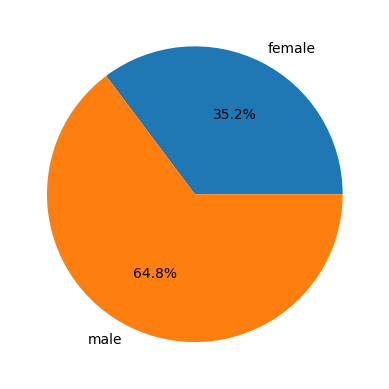

In [11]:
response = query_engine.query("Using a pie chart, plot the distribution of passengers with respect to sex.")
display(Markdown(f"{response}"))


> Pandas Instructions:
```
df.groupby('pclass').size().plot(kind='bar')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


Axes(0.125,0.11;0.775x0.77)

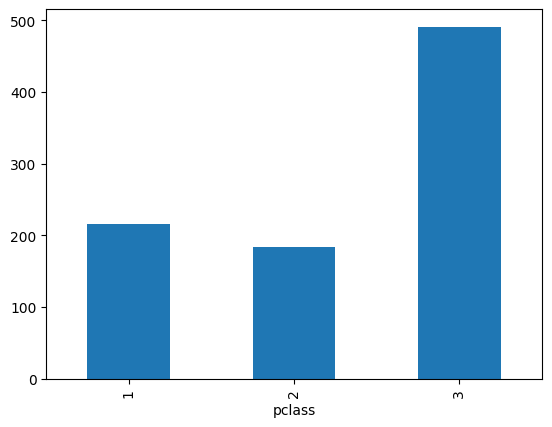

In [12]:
response = query_engine.query("Using a barchart, plot how many passengers were in each class.")
display(Markdown(f"{response}"))

> Pandas Instructions:
```
df.survived.value_counts(normalize=True).plot(kind='bar')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


Axes(0.125,0.11;0.775x0.77)

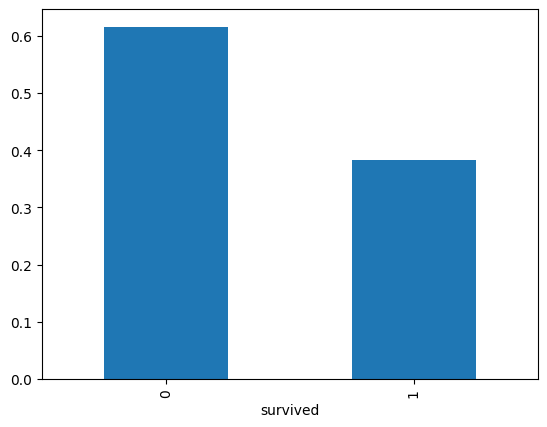

In [13]:
response = query_engine.query("Visualize the percentage of passengers who survived and those who didn’t.")
display(Markdown(f"{response}"))

> Pandas Instructions:
```
df.plot(kind='scatter', x='age', y='fare')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


Axes(0.125,0.11;0.775x0.77)

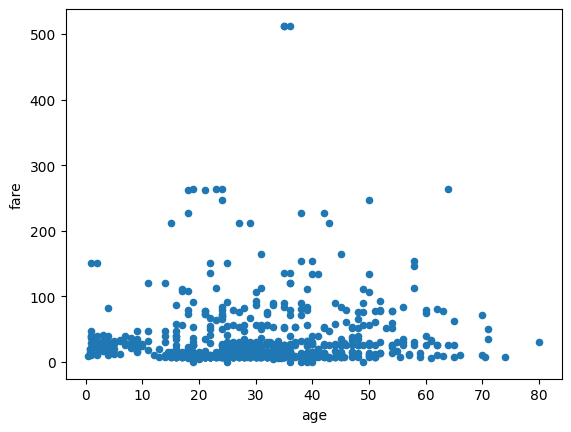

In [14]:
response = query_engine.query("See if there's a relationship between age and fare paid.")
display(Markdown(f"{response}"))

> Pandas Instructions:
```
df.groupby('embarked')['survived'].mean().plot(kind='bar')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


Axes(0.125,0.11;0.775x0.77)

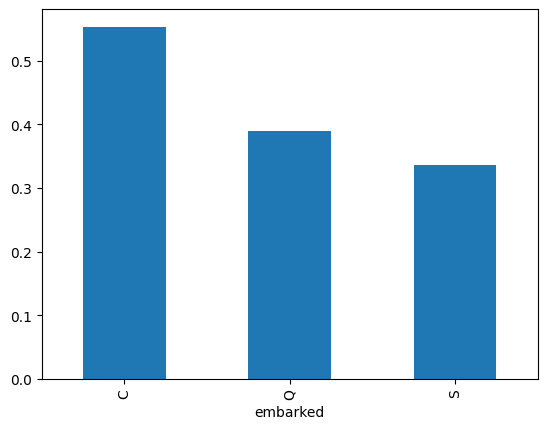

In [15]:
response = query_engine.query("Plot survival rates based on embarkation ports (C = Cherbourg, Q = Queenstown, S = Southampton)")
display(Markdown(f"{response}"))

> Pandas Instructions:
```
df.plot(x='fare', y='survived', kind='scatter')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


Axes(0.125,0.11;0.775x0.77)

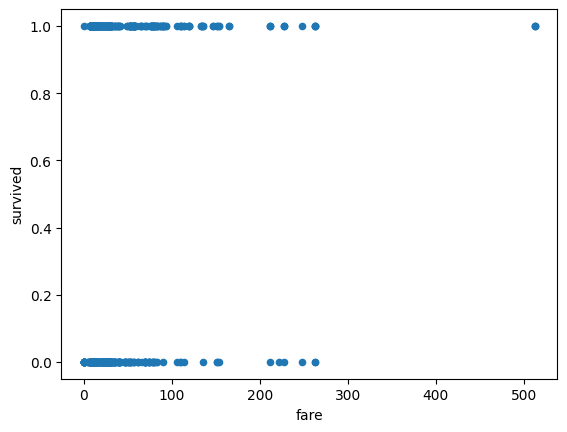

In [16]:
response = query_engine.query("Visualize how the logistic regression model predicts the survival probability based on the fare paid by passengers.")
display(Markdown(f"{response}"))

> Pandas Instructions:
```
df.groupby(pd.cut(df['age'], bins=range(0, 101, 10))).survived.mean().plot(kind='bar')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)


<string>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Axes(0.125,0.11;0.775x0.77)

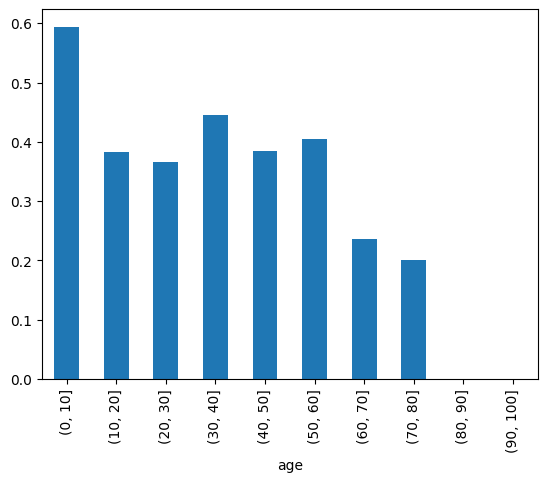

In [17]:
response = query_engine.query("Plot survival rates grouped by age ranges (e.g., 0-10, 11-20, etc.).")
display(Markdown(f"{response}"))